In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
drive.mount('/content/drive/')

model_index = 1
ROUND = ["","_round2"][1]
MODEL_NAME = ["ViT", "BERT"][model_index]
NUMBER_OF_CLASSES = [1000, 77][model_index]

Mounted at /content/drive/


In [ ]:
report_file_address = f"drive/MyDrive/my_projects/transformers/{MODEL_NAME}/generated_data/report{ROUND}.csv"
report_training_file_address = f"drive/MyDrive/my_projects/transformers/{MODEL_NAME}/generated_data/report_training{ROUND}.csv"
attentions_features_address = f"drive/MyDrive/my_projects/transformers/{MODEL_NAME}/generated_data/attentions_features{ROUND}.npy"
attentions_features_training_address = f"drive/MyDrive/my_projects/transformers/{MODEL_NAME}/generated_data/attentions_features_training{ROUND}.npy"

report_df = pd.read_csv(report_file_address)
attentions_features_np = np.load(attentions_features_address)
report_training_df = pd.read_csv(report_training_file_address)
attentions_features_training_np = np.load(attentions_features_training_address)

# Analysis

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn

def generate_report(report_df):
  print("Error Rate:", report_df['predicted_wrong'].mean())
  print("Covered Classes:", np.unique(report_df['real_class']).__len__(), np.unique(report_df['real_class']).__len__()/NUMBER_OF_CLASSES)
  print("Predicted Classes:", np.unique(report_df['predicted_class']).__len__(), np.unique(report_df['predicted_class']).__len__()/NUMBER_OF_CLASSES)
  print("Unique Data Points:", np.unique(report_df['seed_image_index']).__len__(), np.unique(report_df['seed_image_index']).__len__()/len(report_df))
  print("Classes Balance:", report_df[['seed_image_index', 'predicted_wrong']].groupby('predicted_wrong').count())

  sn.displot(np.unique(report_df['seed_image_index'],return_counts=True)[1]) # TODO: rename seed_image_index to seed_index
  plt.title('Number of Repeated Data Points and Their Repetition')
  plt.show()
  sn.displot(report_df[['real_class', 'predicted_wrong']].groupby('real_class').count()['predicted_wrong'])
  plt.title('Number of Data Points per Class')
  plt.show()
  sn.displot(report_df[['real_class', 'predicted_wrong']].groupby('real_class').mean()['predicted_wrong'])
  plt.title('Error Rate per Class')
  plt.show()
  print("error:", report_df['predicted_wrong'].mean())

generate_report(report_training_df)
print("#####################################################")
generate_report(report_df)

In [ ]:
attentions_features_np.shape

(10000, 2658)

In [ ]:
report_df["predicted_wrong"].values

array([1, 1, 0, ..., 0, 1, 0])

# Feature Engineering

In [ ]:
features = attentions_features_np.copy()
features_training = attentions_features_training_np.copy()

## RF Feature Selection (Dimension Reduction)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
clf = RandomForestClassifier()

# Train the classifier
# clf.fit(features, report_df["predicted_wrong"].values)
clf.fit(features_training, report_training_df["predicted_wrong"].values)

# Get feature importances
importances = clf.feature_importances_

number of important feature: 359


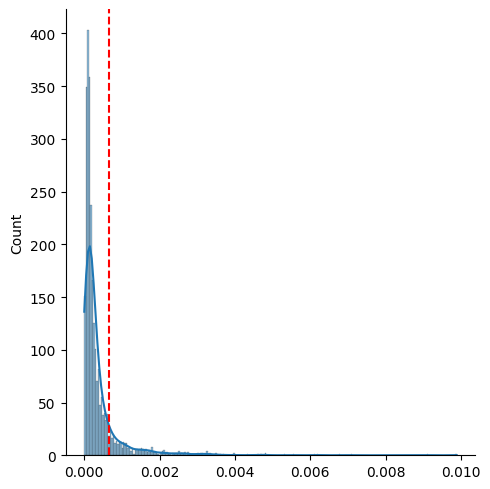

In [ ]:
sn.displot(clf.feature_importances_, kde=True)
feature_importance_threshold = 0.00065
plt.axvline(x=feature_importance_threshold, color='red', linestyle='--')
print("number of important feature:", (clf.feature_importances_>feature_importance_threshold).sum())

In [ ]:
features = features[:,clf.feature_importances_>feature_importance_threshold]
features_training = features_training[:,clf.feature_importances_>feature_importance_threshold]
features.shape

(10000, 359)

### Features Importance Analysis

In [ ]:
matrix = np.arange(144).reshape((12,12))
attention1_flow_index, attention2_flow_index = np.triu_indices_from(matrix,1)

# Data from the table
feature_types = ["attention_entropy", "attention_positive_impact", "attention_negative_impact", "max_attention_weight",
                 "avg_max_attention_weight", "upper_triangle_jsd_matrix", "attention_sparsity", "attention_class_weights_q0",
                 "attention_class_weights_q1", "attention_class_weights_q2", "attention_class_weights_q3", "attention_class_weights_q4",
                 "attention_tokens_weights_q0", "attention_tokens_weights_q1", "attention_tokens_weights_q2", "attention_tokens_weights_q3",
                 "attention_tokens_weights_q4", "attention_balance", "attention_uniformity"]
feature_names = []
layers = []
feature_types_per_attention = []
attention_index = []

for feature_type in feature_types:
  max_feature_index = int(144/2-12/2) if (feature_type == "upper_triangle_jsd_matrix") else 144
  if feature_type != "upper_triangle_jsd_matrix":
    feature_names = feature_names + [f"{feature_type}_att{i}" for i in range(1,1 + (max_feature_index))]
  else:
    feature_names = feature_names + [f"{feature_type}_att{attention1_flow_index[i]+1}_att{attention2_flow_index[i]+1}" for i in range(max_feature_index)]
  layers = layers + [int(i/12) + 1 for i in range(max_feature_index)]
  attention_index = attention_index + [int(i%12) + 1 for i in range(max_feature_index)]
  feature_types_per_attention = feature_types_per_attention + [feature_type for i in range(1,1 + (max_feature_index))]
print("Number of features:", feature_names.__len__())

feature_importances_df = pd.DataFrame()
feature_importances_df["features"] = feature_names
feature_importances_df["importance"] = clf.feature_importances_
feature_importances_df["layers"] = layers
feature_importances_df["attention_index"] = attention_index
feature_importances_df["feature_types"] = feature_types_per_attention
feature_importances_df["feature_index"] = np.arange(len(feature_names))
feature_importances_df["is_selected"] = (clf.feature_importances_>feature_importance_threshold)
feature_importances_df = feature_importances_df.sort_values(by="importance", ascending=False).reset_index(drop=True)

print(feature_importances_df[["importance", "layers"]].groupby("layers").sum().sort_values(by="importance", ascending=False))
print(feature_importances_df[["importance", "feature_types"]].groupby("feature_types").sum().sort_values(by="importance", ascending=False))
print(feature_importances_df[["importance", "feature_types"]].groupby("feature_types").max().sort_values(by="importance", ascending=False))
print(feature_importances_df.query(f"importance>{feature_importance_threshold}")[["feature_types","features"]].groupby("feature_types").count().sort_values(by="features", ascending=False))

In [ ]:
feature_importances_df

## Robust Scaling

In [ ]:
q1 = np.quantile(features_training, q=0.25, axis=0)
q3 = np.quantile(features_training, q=0.75, axis=0)
iqr = q3 - q1
should_remove = iqr==0
iqr[should_remove] = 1
median = np.median(features_training, axis=0)

features_training = (features_training - median) / iqr
features = (features - median) / iqr

features_training = features_training[:,np.logical_not(should_remove)]
features = features[:,np.logical_not(should_remove)]

print(features_training.shape, features.shape)

(10000, 359) (10000, 359)


# Improved K-Means

In [ ]:
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

class kmeans_plus:
  def __init__(self, n_clusters):
    # Assume X_train is your training data and X_test is your new data
    self.kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)

  def fit(self, X):
    self.kmeans.fit(X)
    # Calculate the maximum distance to centroid for each cluster in training data
    self.clusters_max_distances = []
    for i in range(self.kmeans.n_clusters):
        cluster_points = X[self.kmeans.labels_ == i]
        centroid = self.kmeans.cluster_centers_[i]
        distances = np.sqrt(((cluster_points - centroid)**2).sum(axis=1))
        self.clusters_max_distances.append(np.max(distances))

  def predict(self, X):
    # Predict clusters for new data
    labels = self.kmeans.predict(X)
    labels = labels.astype(float)
    new_clusters = []
    new_clusters_db_eps = []
    # Check if any point is farther from its centroid than the maximum distance in training data
    for i, label in enumerate(labels):
        label = int(label)
        centroid = self.kmeans.cluster_centers_[label]
        dist = np.sqrt(((X[i] - centroid)**2).sum())
        if dist > self.clusters_max_distances[label]:
            # Assign to a new cluster
            new_label = labels[i] + i/100000
            print(labels[i], dist, self.clusters_max_distances[label], new_label)
            labels[i] = new_label
            if not (labels[i] in new_clusters):
              new_clusters.append(labels[i])
              new_clusters_db_eps.append(self.clusters_max_distances[label])

    return labels

In [ ]:
kmeans = kmeans_plus(n_clusters = 215)
kmeans.fit(features_training)

# Clustering Result Analysis

In [ ]:
report_df

In [ ]:
clustering_report_df = report_df.copy()
clustering_report_df["cluster"] = kmeans.predict(features)

In [ ]:
error_in_clusters = clustering_report_df[["predicted_wrong", "cluster"]].groupby("cluster").mean().reset_index()["predicted_wrong"].values
points_in_clusters = clustering_report_df[["predicted_wrong", "cluster"]].groupby("cluster").count().reset_index()["predicted_wrong"].values
classes_in_clusters = clustering_report_df[["real_class", "cluster"]].groupby("cluster")["real_class"].nunique().values
predicted_classes_in_clusters = clustering_report_df[["predicted_class", "cluster"]].groupby("cluster")["predicted_class"].nunique().values

In [ ]:
feature_types_coverage = []

for row in feature_importances_df[0:features.shape[1]].iterrows():
  row = row[1]
  if row['feature_types'] in feature_types_coverage:
    continue
  else:
    feature_types_coverage.append(row['feature_types'])

  clustering_report_df["feature"] = attentions_features_np[:,row['feature_index']]
  sn.distplot(attentions_features_np[:,row['feature_index']])
  plt.xlabel(row['feature_types'], fontsize=12)
  plt.show()
  points_feature_in_clusters = clustering_report_df[["feature", "cluster"]].groupby("cluster").mean().reset_index()["feature"].values
  points_in_clusters = clustering_report_df[["predicted_wrong", "cluster"]].groupby("cluster").count().reset_index()["predicted_wrong"].values
  print(len(points_in_clusters), points_in_clusters.sum())
  print(row['features'],row['layers'],row['feature_types'],row['feature_index'])

  # Calculate the weighted mean
  weighted_mean_x = np.average(points_feature_in_clusters, weights=points_in_clusters/points_in_clusters.max())
  weighted_mean_y = np.average(error_in_clusters, weights=points_in_clusters/points_in_clusters.max())

  # Calculate the weighted covariance
  weighted_cov = np.average((points_feature_in_clusters-weighted_mean_x)*(error_in_clusters-weighted_mean_y), weights=points_in_clusters/points_in_clusters.max())

  # Calculate the standard deviations considering the weights
  std_x = np.sqrt(np.average((points_feature_in_clusters-weighted_mean_x)**2, weights=points_in_clusters/points_in_clusters.max()))
  std_y = np.sqrt(np.average((error_in_clusters-weighted_mean_y)**2, weights=points_in_clusters/points_in_clusters.max()))

  # Calculate the weighted correlation
  weighted_corr = weighted_cov / (std_x * std_y)

  limit = [30,5][model_index]
  plt.figure(figsize=(2,1))
  sn.displot(x=points_feature_in_clusters[points_in_clusters>limit],
              y=error_in_clusters[points_in_clusters>limit],
              kind="kde")

  if row['feature_types'] == "upper_triangle_jsd_matrix":
    plt.title(f"JSD Between Attentions {attention1_flow_index[row['attention_index']-1]+1} & {attention2_flow_index[row['attention_index']-1]+1} - {MODEL_NAME}", fontsize=12)
  else:
    plt.title(f"Layer {row['layers']} - Attention {row['attention_index']} - {MODEL_NAME}", fontsize=12)
  plt.xlabel(row['feature_types'].replace("_","-"), fontsize=12)
  plt.ylabel("Error in Zones", fontsize=12)


  plt.show()
  print("####################################")

# Coverage Criteria

In [ ]:
import math

clustering_report_training_df = report_training_df.copy()
clustering_report_training_df["cluster"] = kmeans.predict(features_training)
clusters_classes_df = clustering_report_training_df\
                        .drop_duplicates(subset=['cluster', 'real_class'])\
                        .groupby('cluster')['real_class'].apply(list).reset_index()
clusters_classes_dict = {}
for row in clusters_classes_df[["cluster", "real_class"]].iterrows():
  row = row[1]
  clusters_classes_dict[row["cluster"]] = row["real_class"]
del clusters_classes_df

clustering_report_df = report_df.copy()
clustering_report_df["cluster"] = kmeans.predict(features)
clustering_report_df["is_beyond_centroid_zone"] = clustering_report_df["cluster"].apply(lambda x: math.modf(x)[0] != 0)
clustering_report_df["is_new_class_in_centroid_zone"] =\
  clustering_report_df[["real_class","cluster","is_beyond_centroid_zone"]]\
  .apply(lambda x: False if x["is_beyond_centroid_zone"] else not(x["real_class"] in clusters_classes_dict[x["cluster"]]), axis=1)

In [ ]:
def get_beyond_centroid_zone_coverage_sample_error(sample_df: pd.DataFrame) -> float:
  agg_df = sample_df.query("is_beyond_centroid_zone==True")[["cluster", "predicted_wrong"]].groupby("cluster").agg(["count","mean"]).reset_index()
  agg_df.columns = ['cluster', 'count', 'mean']
  covered_area_error = (agg_df["count"] * agg_df["mean"]).sum()/agg_df["count"].sum()
  return covered_area_error

def get_centroid_zone_coverage_sample_error(sample_df: pd.DataFrame) -> float:
  agg_df = sample_df.query("is_beyond_centroid_zone==False")[["cluster", "predicted_wrong"]].groupby("cluster").agg(["count","mean"]).reset_index()
  agg_df.columns = ['cluster', 'count', 'mean']
  covered_area_error = (agg_df["count"] * agg_df["mean"]).sum()/agg_df["count"].sum()
  return covered_area_error

def get_new_class_in_centroid_zone_coverage_sample_error(sample_df: pd.DataFrame) -> float:
  agg_df = sample_df.query("is_new_class_in_centroid_zone==True")[[
        "cluster", "real_class", "predicted_wrong"
      ]].groupby(["cluster", "real_class"]).agg(["count","mean"]).reset_index()
  agg_df.columns = ['cluster', 'real_class', 'count', 'mean']
  covered_area_error = (agg_df["count"] * agg_df["mean"]).sum()/agg_df["count"].sum()
  return covered_area_error

def get_basic_class_in_centroid_zone_coverage_sample_error(sample_df: pd.DataFrame):
  agg_df = sample_df.query("(is_new_class_in_centroid_zone==False)and(is_beyond_centroid_zone==False)")[[
        "cluster", "real_class", "predicted_wrong"
      ]].groupby(["cluster", "real_class"]).agg(["count","mean"]).reset_index()
  agg_df.columns = ['cluster', 'real_class', 'count', 'mean']
  covered_area_error = (agg_df["count"] * agg_df["mean"]).sum()/agg_df["count"].sum()
  return covered_area_error

def get_all_classes_beyond_centroid_zone_coverage_sample_error(sample_df: pd.DataFrame):
  agg_df = sample_df.query("is_beyond_centroid_zone==True")[[
        "cluster", "real_class", "predicted_wrong"
      ]].groupby(["cluster", "real_class"]).agg(["count","mean"]).reset_index()
  agg_df.columns = ['cluster', 'real_class', 'count', 'mean']
  covered_area_error = (agg_df["count"] * agg_df["mean"]).sum()/agg_df["count"].sum()
  return covered_area_error

## Kolmogorov Test

In [ ]:
samples_error = []
bczc_errors = []
czc_errors = []
ncczc_errors = []
bcczc_errors = []
acbczc_errors = []

for sample_index in range(1000):
  sample = np.random.choice(len(features), 1000, replace=False)
  sample_df = clustering_report_df.iloc()[sample].reset_index(drop=True)
  samples_error.append(
      sample_df["predicted_wrong"].mean()
  )
  bczc_errors.append(
      get_beyond_centroid_zone_coverage_sample_error(sample_df)
  )
  czc_errors.append(
      get_centroid_zone_coverage_sample_error(sample_df)
  )
  ncczc_errors.append(
      get_new_class_in_centroid_zone_coverage_sample_error(sample_df)
  )
  bcczc_errors.append(
      get_basic_class_in_centroid_zone_coverage_sample_error(sample_df)
  )
  acbczc_errors.append(
      get_all_classes_beyond_centroid_zone_coverage_sample_error(sample_df)
  )
  if (sample_index % 100) == 0:
    print("progress:", sample_index)

In [ ]:
from scipy import stats

for coverage_criteian_name, coverage_error in zip(
      ["Beyond Centroid Zone Coverage", "Centroid Zone Coverage", "New Centroid Coverage (NCC)",
       "Basic Centroid Coverage (BCC)", "Extended Centroid Coverage (ECC)"],
      [bczc_errors, czc_errors, ncczc_errors, bcczc_errors, acbczc_errors],
    ):

  # Perform the Kolmogorov-Smirnov test
  D, p_value = stats.ks_2samp(samples_error, coverage_error)

  print('D statistic:', D)
  print('p-value:', p_value)

  sn.kdeplot(coverage_error, fill=True, label="Coverage Error")
  sn.kdeplot(samples_error, fill=True, label="Sample Error")
  plt.title(coverage_criteian_name)
  plt.legend()
  plt.show()

# Binary Classifier (Error Prediction)

In [ ]:
X = features[:int(len(features)*0.7),:]
y = report_df["predicted_wrong"].values[:int(len(features)*0.7)]

X_test = features[int(len(features)*0.7):,:]
y_test = report_df["predicted_wrong"].values[int(len(features)*0.7):]

print(X.shape, y.shape, X_test.shape, y_test.shape)

(7000, 359) (7000,) (3000, 359) (3000,)


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def make_report(y,y_p):
  accuracy = 1-(np.abs(y-y_p).sum()/len(y))
  precision = np.sum(y[y_p==1]) / np.sum(y_p)
  recall = np.sum(y_p[y==1]) / np.sum(y)

  report_df = pd.DataFrame()
  report_df['accuracy'] = [accuracy]
  report_df['precision'] = [precision]
  report_df['recall'] = [recall]

  return report_df

def plot_roc(y, y_p):
  # Compute the ROC curve
  fpr, tpr, thresholds = roc_curve(y, y_p)

  # Compute the AUC
  roc_auc = auc(fpr, tpr)

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

## RF Binary Classifier

In [ ]:
clf = RandomForestClassifier(max_depth=None)
clf.fit(X, y)

y_p = clf.predict_proba(X_test)[:,1]
plot_roc(y_test, y_p)

y_p = clf.predict(X_test)
make_report(y_test,y_p)

## SVM

In [ ]:
from sklearn import svm

clf = svm.SVC(probability=True)
clf.fit(X, y)

y_p = clf.predict_proba(X_test)[:,1]
plot_roc(y_test, y_p)

y_p = clf.predict(X_test)
make_report(y_test, y_p)